# Demonstration of dql

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/Users/robertyi/repos/dataframe/dpipe')
from dpipe import *
from dpipe.sampledata.datagen import user_data, purchase_data
import dpipe as dp

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Create some synthetic data
Let's start by making some synthetic data. Below I use some boilerplate numpy + pandas code to generate some weekly fluctuating revenue data.

In [5]:
users = user_data(1000, random_state=2701)
purchases = purchase_data(1000)

## Overview of data
We have two tables:

* `users`
* `purchases`

These should roughly mirror the kind of information companies will typically log (if star schema is being used) -- dimension tables describing *states*, such as a user information table; fact tables describing *events*, such as a purchases or visits table.

We'll assume we've loaded these as `pd.DataFrame`s from your data lake. Let's see how we would traditionally parse these.

## Plotting

Even for basic plotting of time trends, this can be quite cumbersome. Tools like superset and tableau make this significantly easier, but for data scientists who like to stay within the python ecosystem, substantial cleaning will nonetheless be required.

### Histograms

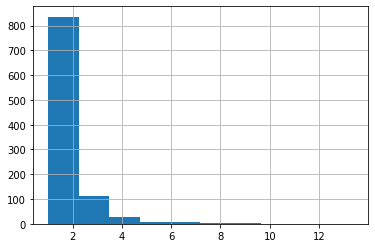

In [4]:
purchases.sale_value.hist()

Histograms are quite easy to plot, but typically some sort of log-scaling is necessary, especially for long-tailed distributions.

Iterations are usually required.

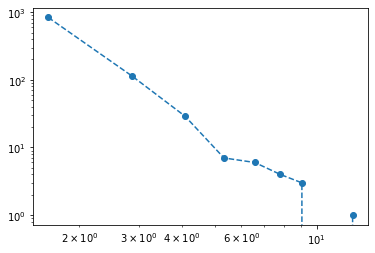

In [5]:
y, x = np.histogram(purchases.sale_value)
plt.plot((x[1:] + x[:-1])/2, y, 'o--')
plt.xscale('log')
plt.yscale('log')

`dpipe` makes this just as easy, but with a few small QOL improvements:

* Declarative syntax.
* Automatic ipython-suitable styling.
* Better defaults.

Moreover, the functions wrap matplotlib/pandas/numpy, so any arguments that apply to the base functions can be passed.

In [28]:
# We support dark mode (not on by default).
# Enabling it here because we like it.
import dpipe
dpipe.style.rc['style'] = 'dark_mode'

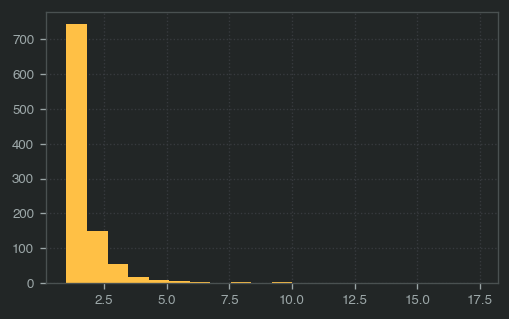

In [29]:
a = purchases.sale_value >> Hist(bins=20);

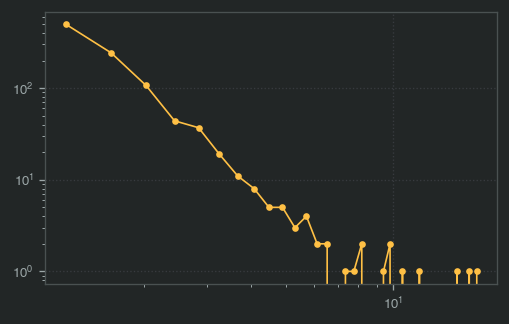

In [30]:
purchases.sale_value >> LogLogHist(bins=40)

## Scatter plots

In [31]:
a, b, c = np.array_split(users, 3)

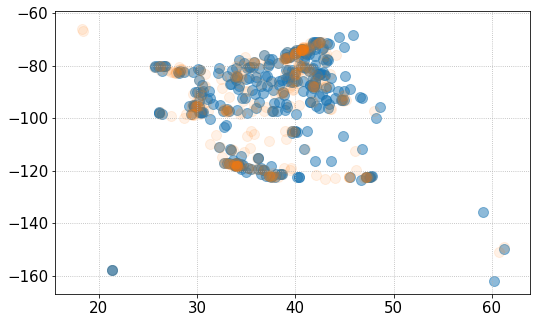

In [62]:
plt.figure(figsize=(8.5,5.2))
plt.scatter(a.lat, a.lng, alpha=0.5, s=100)
plt.scatter(b.lat, b.lng, alpha=0.1, s=100)
plt.scatter(c.lat, c.lng, alpha=0.1, s=100)
plt.grid('on', linestyle=':')
plt.rcParams.update({'font.size': 15})

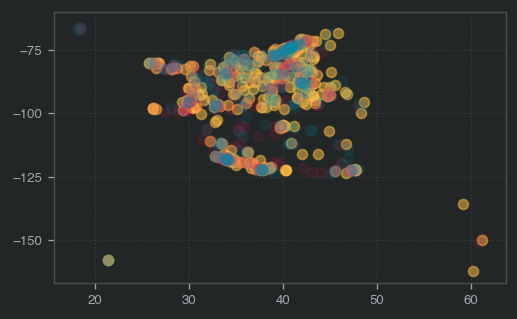

In [61]:
(a.lat, a.lng) >> Scatter
(b.lat, b.lng) >> Scatter(alpha=0.1)
(c.lat, c.lng) >> Scatter(alpha=0.1)

## Aggregations

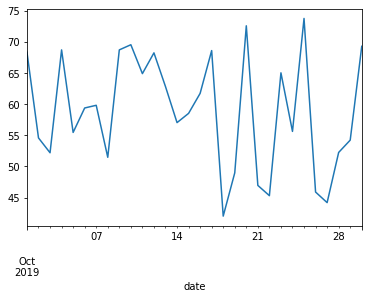

In [12]:
purchases_copy = purchases.copy()
purchases_copy['date'] = pd.to_datetime(purchases_copy.date)
gb = purchases_copy.groupby('date').sum()['sale_value']
gb.plot()

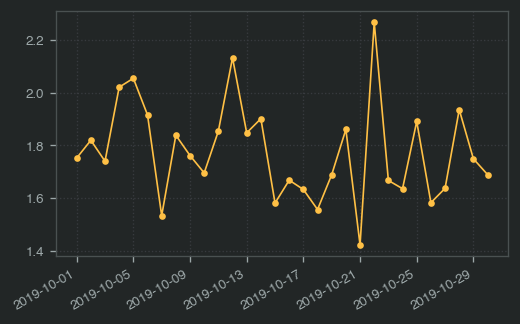

In [13]:
purchases >> GroupBy('date') >> Mean('sale_value') >> Plot

## Light mode

In [14]:
import dpipe
dpipe.style.rc['style'] = 'light_mode'

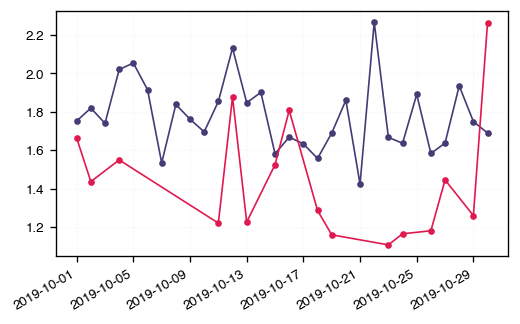

In [19]:
purchases >> GroupBy('date') >> Mean('sale_value') >> Plot

new_purchases = purchases.sample(20, replace=True)
new_purchases >> GroupBy('date') >> Mean('sale_value') >> Plot

## ML

In [66]:
import numpy as np
import sklearn
df = pd.merge(users, purchases, on='id_user')
df = df[['population', 'density', 'sale_value']]
X = df[['population', 'density']]
y = df['sale_value']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
reg = sklearn.linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)
print('Mean squared error:', sklearn.metrics.mean_squared_error(y_train, y_train_pred))
print('Mean absolute error:', sklearn.metrics.mean_absolute_error(y_train, y_train_pred))
print('Root mean squared error:', np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_train_pred)))
print('Mean squared error:', sklearn.metrics.mean_squared_error(y_test, y_pred))
print('Mean absolute error:', sklearn.metrics.mean_absolute_error(y_test, y_pred))
print('Root mean squared error:', np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred)))

Mean squared error: 4.899352486891473
Mean absolute error: 1.5548264004874963
Root mean squared error: 2.2134480989830037
Mean squared error: 9.82684370307429
Mean absolute error: 1.9531972841580834
Root mean squared error: 3.134779689718927


In [23]:
modelspec = (users, purchases) \
    >> Merge(on='id_user') \
    >> Select('population', 'density', 'sale_value') \
    >> SpecifyLabel('sale_value') \
    >> TrainTestSplit \
    >> LinearReg

Training set
------------ 
Max error: 6.484432823001604
Mean absolute error: 2.0133895701391276
Mean squared error: 7.48598746333977
Root mean squared error: 2.73605326398076


Test set
-------- 
Max error: 2.6105036207962025
Mean absolute error: 1.994895347220754
Mean squared error: 4.10127705434591
Root mean squared error: 2.0251609946732407
